The downstream study based on sklearn framework.
====================
Study of the seed selection
-----------------------------

At first I want to look at the input data and then prepare baseline for further studies. 
I would like to use fisher and BDT as a baseline clasifiers. And then more sophisticated models (deep NN) will be used. 

In [1]:
import root_numpy
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import ROOT
%matplotlib inline

Welcome to JupyROOT 6.07/07


As a very first step I need to grab training data form the NTpule. 
--------------------------

In [2]:
root_file = ROOT.TFile("datasets/Brunel_preselection_5kev.root")
root_file.cd("ToolSvc.PatDebugTTTruthTool")
tree = ROOT.gDirectory.Get("DownstreamSeedDebugTuple")
data = pd.DataFrame(root_numpy.tree2array(tree))

target = data.is_true_seed
features = data.drop("is_true_seed", axis=1).astype(numpy.float64)

In [3]:
data.head()

,is_true_seed,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
0,True,1.213708,2543.471925,1187.267858,25,0,12,-1263.157617,-517.249191,-0.524220,-0.061572
1,True,1.346112,2781.485771,1204.396954,25,0,12,1264.522435,-99.363473,0.480288,-0.009081
2,False,1.627632,4769.446536,1708.511389,25,0,12,-1521.093160,-196.064807,-0.382802,-0.025975
3,False,1.789231,5202.918132,1823.936187,25,0,12,-1563.145597,-483.850246,-0.369674,-0.058753
4,True,1.269238,2300.960611,1252.585447,24,0,12,-1641.727752,-411.084316,-0.646627,-0.054980


Print the features
-------------------------

In [4]:
features.describe()

,seed_chi2PerDoF,seed_p,seed_pt,seed_nLHCbIDs,seed_nbIT,seed_nLayers,seed_x,seed_y,seed_tx,seed_ty
count,337291.000000,3.372910e+05,3.372910e+05,337291.000000,337291.000000,337291.000000,337291.000000,337291.000000,337291.000000,337291.000000
mean,1.517037,2.211789e+04,2.196243e+03,18.722554,3.151878,11.539300,15.402574,-1.379834,0.010450,-0.000132
std,0.829149,7.881846e+05,8.590252e+04,4.734461,5.052006,0.809568,706.761944,477.788969,0.291848,0.061804
min,0.002426,1.197563e+03,1.762072e+00,8.000000,0.000000,8.000000,-2455.114846,-2126.348264,-1.118789,-0.406831
25%,0.909067,3.532194e+03,9.944996e+02,13.000000,0.000000,11.000000,-372.118440,-187.880756,-0.150078,-0.026654
50%,1.346665,6.760680e+03,1.155453e+03,20.000000,0.000000,12.000000,13.148397,0.066661,0.011061,0.000014
75%,1.963339,1.520037e+04,1.399159e+03,22.000000,8.000000,12.000000,411.256885,185.720268,0.174055,0.026627
max,8.792842,3.601153e+08,3.166954e+07,32.000000,20.000000,12.000000,2421.930280,2141.645310,1.132967,0.348517


In [5]:
def print_features_histograms(features):
    hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
    # create the figure
    fig = plt.figure(figsize=(16,  25))
    for n, feature in enumerate(features):
        # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        # define range for histograms by cutting 1% of data from both ends
        min_value, max_value = numpy.percentile(data[feature], [1, 99])
        ax.hist(data.ix[data.is_true_seed.values == 0, feature].values, range=(min_value, max_value), 
                 label='ghost', **hist_params)
        ax.hist(data.ix[data.is_true_seed.values == 1, feature].values, range=(min_value, max_value), 
                 label='true', **hist_params)
        ax.legend(loc='best')

        ax.set_title(feature)

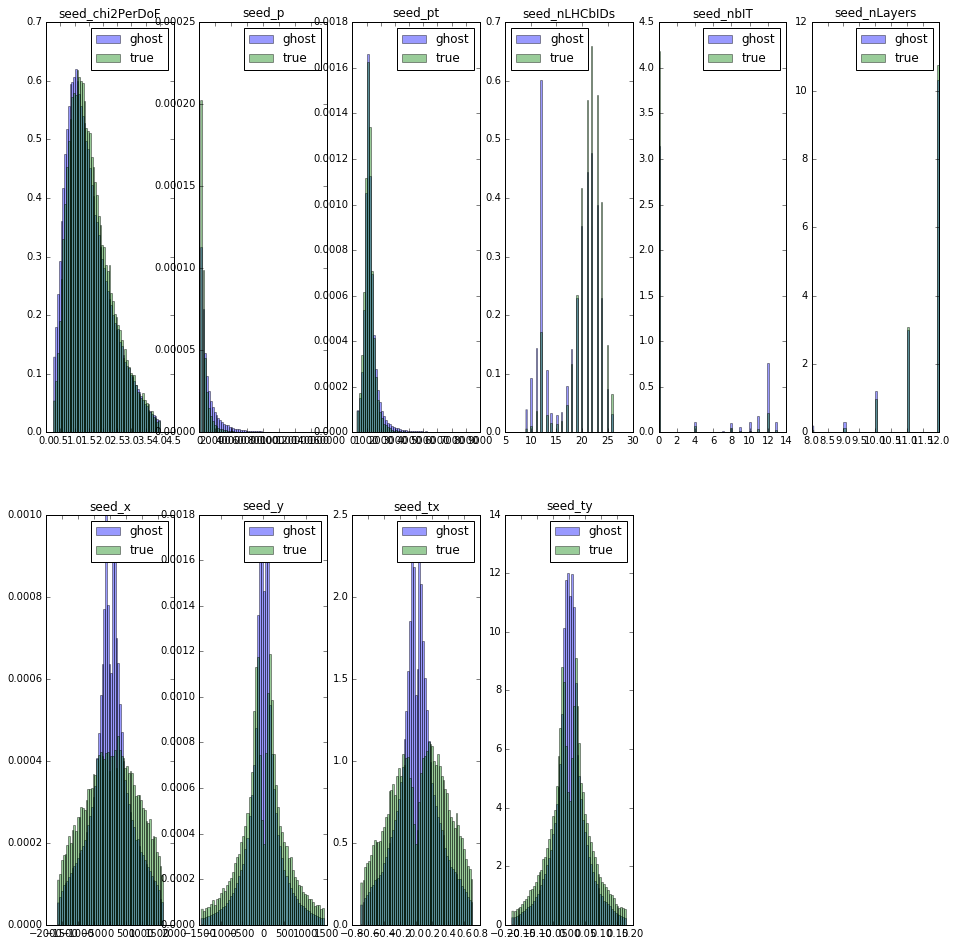

In [6]:
print_features_histograms(features)

In [7]:
def feature_boxplot(features):
    for n, feature in enumerate(features):
    # add sub plot on our figure
        ax = fig.add_subplot(features.shape[1] // 5 + 1, 6, n + 1)
        data.boxplot(feature,by='is_true_seed', ax=ax, whis='range');
        ax.legend(loc='best')      

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


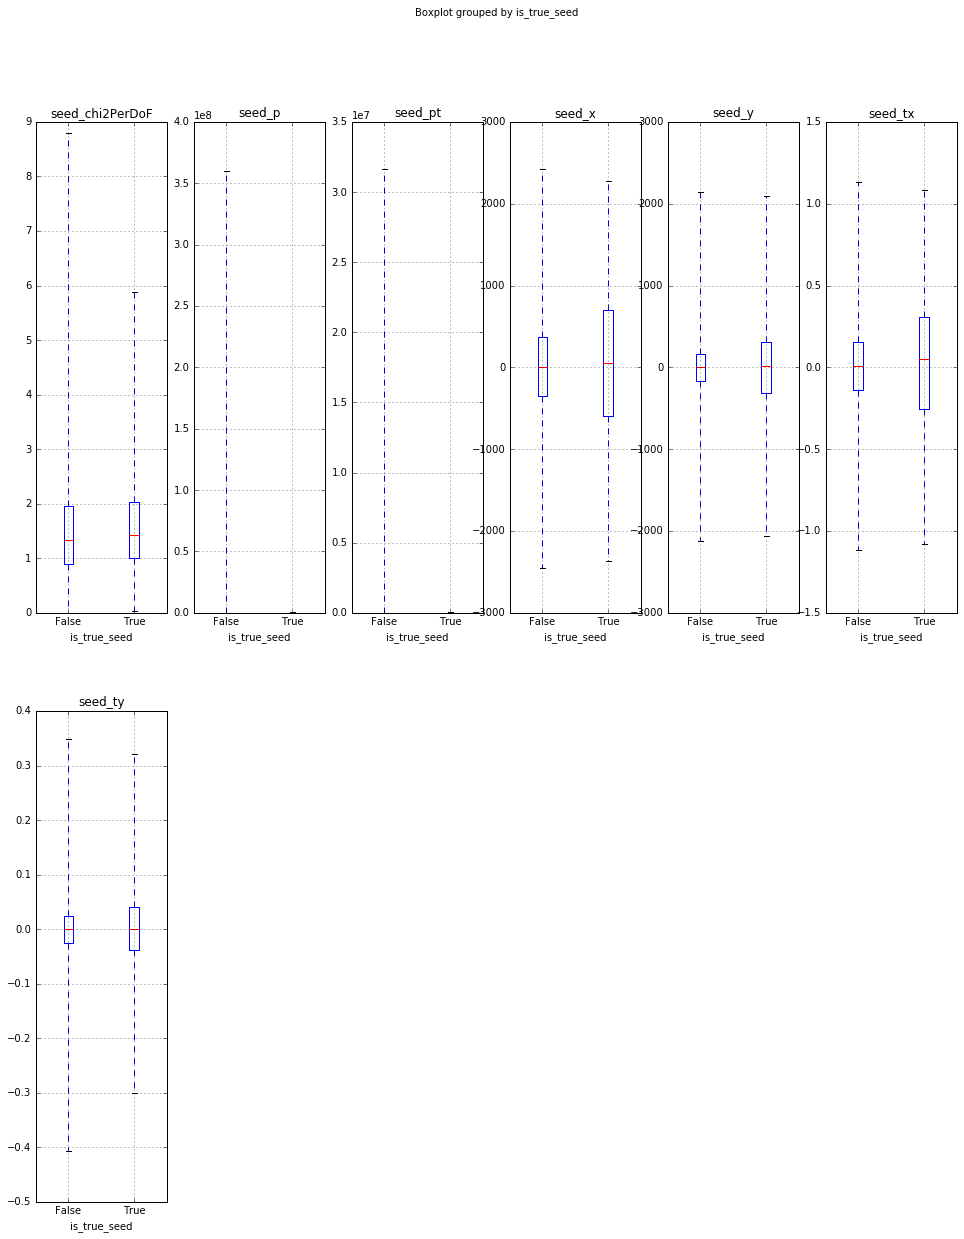

In [8]:
fig = plt.figure(figsize=(16,  20))
real_data_features = features.drop(['seed_nbIT','seed_nLHCbIDs', 'seed_nbIT','seed_nLayers' ],axis=1)
feature_boxplot(real_data_features)

Training of the baselines's clasifiers
=======================

Split data into train and validation sets
----------------------

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
trainX, testX, trainY, testY = train_test_split(features, target, random_state=42,train_size=0.9 )

At first try kNN. 
---------------
As a k I choose arbitrary value equal to 6. This value can be tuned via grid search but it is pointless. 
I am not using any of the feature engenering. I just want to create very low level baseline.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(trainX,trainY)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform')

In [11]:
print "ROC AUC score"
roc_auc_score(testY, knn.predict_proba(testX)[:, 1])

0.68977973169083717

ROC AUC score


Cross Validation score

In [12]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(knn,
                                          testX, testY,
                                          scoring="roc_auc",
                                          n_jobs=6,
                                          cv=3);
"Accuracy: %0.5f (+/- %0.5f)"%(scores.mean(), scores.std())

'Accuracy: 0.67469 (+/- 0.00509)'

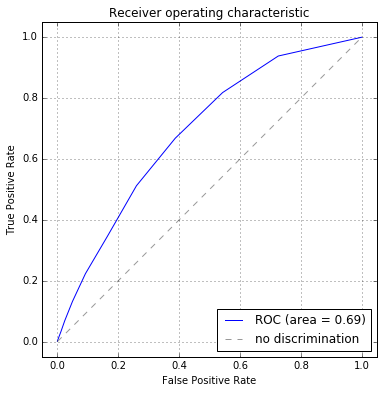

In [13]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(testY, knn.predict_proba(testX)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Hyperparameters optimalization
----------------
Let's improve it by serching for the best hyperparameters values. For the very basic algorithm like kNN we can only play with:
* k - number of neighbours. 
  * The cosidered range of k is between 5 and 50
* metrics. Possible choices see [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html)
* We can also look at the different optimalization algorithms such as BallTree or KDTree. But it should has no impact on classiffier performance

In [ ]:
from sklearn import grid_search
from sklearn.metrics import classification_report
knn_grid_params = {"n_neighbors": [x  for x in range(19,51) if x % 5  == 0],
                  "metric": ['minkowski', 'euclidean', 'canberra']}
clf = grid_search.GridSearchCV(knn,
                               knn_grid_params,
                               cv=3,
                               scoring='roc_auc',
                               n_jobs=8);
clf.fit(trainX, trainY);

In [ ]:
print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
        % (mean_score, scores.std() * 2, params))

print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
y_true, y_pred = testY, clf.predict(testX)
print(classification_report(y_true, y_pred))
print()

Boosted Decision Tree clasifier
------------------------------
The above plots present's performance of the 

Feature Engenering
---------------
At the begining let's try some very basic feature transformation. For instance log the momentums and take abs of simetrical distributed features. 

In [ ]:
def basic_transforamtion(data):
    pass